In [38]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [49]:
from matrix import waxman
from plot import scatter_3d

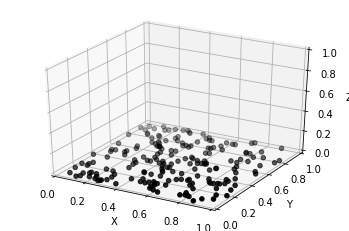

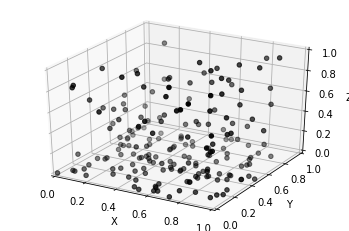

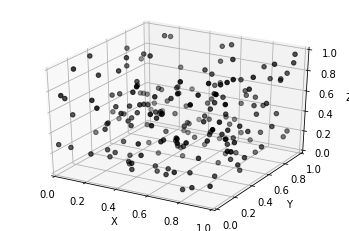

In [58]:
for z_frac in [0.0, 0.5, 1.0]:
    G = waxman(n=200, alpha=1.0, beta=1.0, z_frac=z_frac)
    scatter_3d(G)